In [71]:
from torch import nn, optim
from torch.utils.data import dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import control


class FCnet(nn.Module):

    def __init__(self, input_size, output_size, n_layers, layer_size):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, layer_size)])
        self.layers.extend(nn.Linear(layer_size, layer_size) for _ in range(n_layers - 2))
        self.layers.append(nn.Linear(layer_size, output_size))
        self.layer_size = layer_size
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight, gain=1)
        self.input_size = input_size
        self.layer_size = layer_size
        self.tanh = nn.Hardtanh(min_val=-1, max_val=1)

    def forward(self, x):
        y = self.tanh(self.layers[0](x))
        for i in range(1, len(self.layers)):
            y = self.tanh(self.layers[i](y))
        return y


def train(model, epochs, train_loader, loss):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        losses = []
        for x, y in train_loader:
            prediction = model(x)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.item())
            optimizer.zero_grad()
            loss_batch.backward()
            optimizer.step()
        print('epoch {e}, mse {m}'.format(e=epoch, m=np.mean(losses)))

def test(model, test_loader, loss):
    losses = []
    for x, y in test_loader:
        prediction = model(x)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
    return np.mean(losses)

In [72]:
system = control.TransferFunction(np.array([1, 0]), np.array([1, -7/12, 1/4, -1/24]), 1)

In [155]:
def color_gen():
    colors = ['green', 'blue', 'red']
    i = 0
    while True:
        yield colors[i]
        i += 1
        i = i % len(colors)


def plot_discrete_output(file_name=None, **kwargs):
    for elem in kwargs.keys():
        if type(kwargs[elem]) == torch.Tensor:
            kwargs[elem] = kwargs[elem].detach().numpy().ravel()
    data_dict = kwargs
    assert len(set((elem.shape for elem in data_dict.values()))) == 1
    fig, ax = plt.subplots()
    for label, data, color in zip(data_dict.keys(), data_dict.values(), color_gen()):
        # ax.set_ylim((-0.5, 0.5))
        ax.set_xticks(np.arange(data.shape[0]))
        ax.set_xlabel('Момент времени', fontsize=15)
        ax.set_ylabel('Выход системы', fontsize=15)
        ax.scatter(x=np.arange(data.shape[0]), y=data, label=label, color=color)
        
    ax.legend(fontsize=15, loc="upper right")
    ax.grid()
    counter = 0
    for tic in ax.xaxis.get_major_ticks():
        if counter % 10 != 0:
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False
        counter += 1
    fig.set_size_inches((10, 10))
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name)

In [74]:
def func(impact_time):
    return np.sin(np.arange(impact_time) * 0.1) / 2

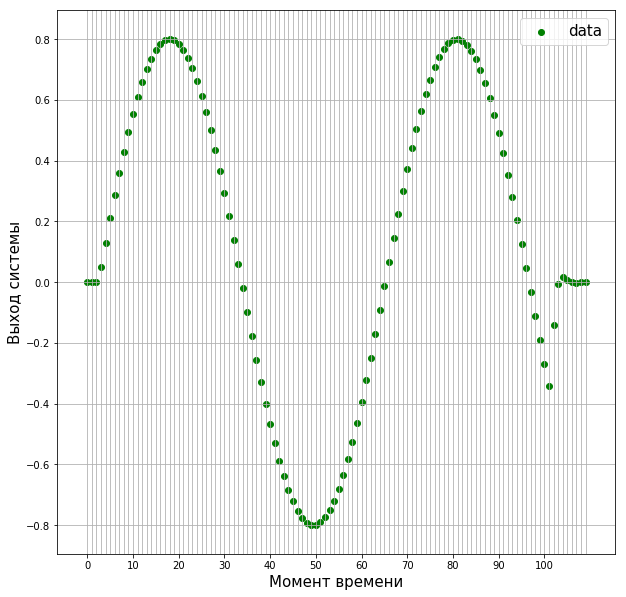

In [75]:
impact_time = 100
cooldown_time = 10 
U = np.concatenate((func(impact_time), np.zeros(cooldown_time)))
output = control.forced_response(system, T=np.arange(impact_time + cooldown_time), U=U)[1]
plot_discrete_output(
    file_name='tmp.png',
    data=output[0]
)

In [76]:
control.margin(system)

(0.625, 36.67860882036618, 0.0, 1.036960862501573)

### Проверка на случайных синусоидах с различным периодом (амплитуда фиксирована)

In [77]:
class ControlDataset(dataset.Dataset):
    
    def __init__(self, global_u, global_y):
        assert len(global_u) == len(global_y)
        self.global_u = global_u
        self.global_y = global_y
        
    def __getitem__(self, index):
        return self.global_u[index], self.global_y[index]
    
    def __len__(self):
        return len(self.global_u)


def generate_data(control_sys, impact_time, cooldown_time, n_samples, input_func):
    total_time = impact_time + cooldown_time
    global_u = [
        np.concatenate((input_func(impact_time), np.zeros(cooldown_time)))
        for _ in range(n_samples)
    ]
    global_y = [control.forced_response(control_sys, T=np.arange(total_time), U=u)[1] for u in global_u]
    global_u = [torch.tensor(elem.ravel(), requires_grad=True).float() for elem in global_u]
    global_y = [torch.tensor(elem.ravel(), requires_grad=True).float() for elem in global_y]
    
    return ControlDataset(global_u, global_y)

In [78]:
train_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [79]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [91]:
model = FCnet(input_size=train_dataset[0][0].size()[0], output_size=train_dataset[0][1].size()[0], n_layers=5, layer_size=50)

In [92]:
train(model, 100, train_dataloader, nn.MSELoss())

epoch 0, mse 0.04481770185986534
epoch 1, mse 0.0019047889957437291
epoch 2, mse 0.0006481788819655776
epoch 3, mse 0.0004145417868858203
epoch 4, mse 0.00030423299918766136
epoch 5, mse 0.0002064345040707849
epoch 6, mse 0.00013280323677463456
epoch 7, mse 8.930861898988952e-05
epoch 8, mse 6.406484531908063e-05
epoch 9, mse 4.491087063797749e-05
epoch 10, mse 3.287471428848221e-05
epoch 11, mse 3.0571929992220246e-05
epoch 12, mse 2.3215773080664803e-05
epoch 13, mse 2.0458046096791806e-05
epoch 14, mse 2.2855564766359747e-05
epoch 15, mse 1.4617172223552188e-05
epoch 16, mse 4.7865924907455335e-05
epoch 17, mse 7.381800852272135e-05
epoch 18, mse 1.2372382461762755e-05
epoch 19, mse 1.1480672069410503e-05
epoch 20, mse 1.9520080386428162e-05
epoch 21, mse 2.9269677952470374e-05
epoch 22, mse 2.835302806488471e-05
epoch 23, mse 6.420575882657432e-05
epoch 24, mse 5.757139792876842e-05
epoch 25, mse 9.909547500228655e-06
epoch 26, mse 1.995148070363939e-05
epoch 27, mse 9.990181352804

In [94]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=90,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [95]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

среднее MSE для одного сигнала на сгенерированной тестовой выборке

In [96]:
test(model, test_dataloader, nn.MSELoss())

6.18385315328851e-06

In [101]:
test_dataset[0]

(tensor([ 0.0000,  0.0308,  0.0614,  0.0918,  0.1219,  0.1515,  0.1805,  0.2088,
          0.2364,  0.2630,  0.2887,  0.3133,  0.3366,  0.3588,  0.3795,  0.3988,
          0.4166,  0.4328,  0.4474,  0.4603,  0.4714,  0.4808,  0.4883,  0.4940,
          0.4978,  0.4997,  0.4998,  0.4979,  0.4942,  0.4886,  0.4811,  0.4718,
          0.4607,  0.4479,  0.4334,  0.4172,  0.3995,  0.3802,  0.3596,  0.3375,
          0.3142,  0.2896,  0.2640,  0.2374,  0.2099,  0.1816,  0.1526,  0.1230,
          0.0929,  0.0625,  0.0319,  0.0011, -0.0296, -0.0603, -0.0907, -0.1208,
         -0.1504, -0.1794, -0.2078, -0.2354, -0.2621, -0.2878, -0.3124, -0.3358,
         -0.3580, -0.3787, -0.3981, -0.4160, -0.4322, -0.4469, -0.4598, -0.4710,
         -0.4805, -0.4881, -0.4938, -0.4977, -0.4997, -0.4998, -0.4980, -0.4944,
         -0.4888, -0.4814, -0.4722, -0.4612, -0.4484, -0.4340, -0.4179, -0.4002,
         -0.3810, -0.3603,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  

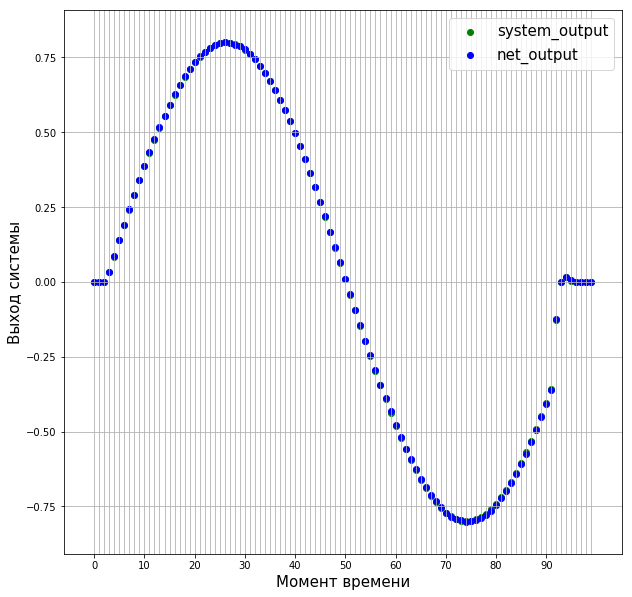

In [105]:
plot_discrete_output(
    system_output=test_dataset[2][1],
    net_output=model(test_dataset[2][0]),
    file_name='low_freq.png'
)

### Высокая частота

In [163]:
train_dataset = generate_data(
    control_sys=system,
    impact_time=100,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=1)) / 2
)

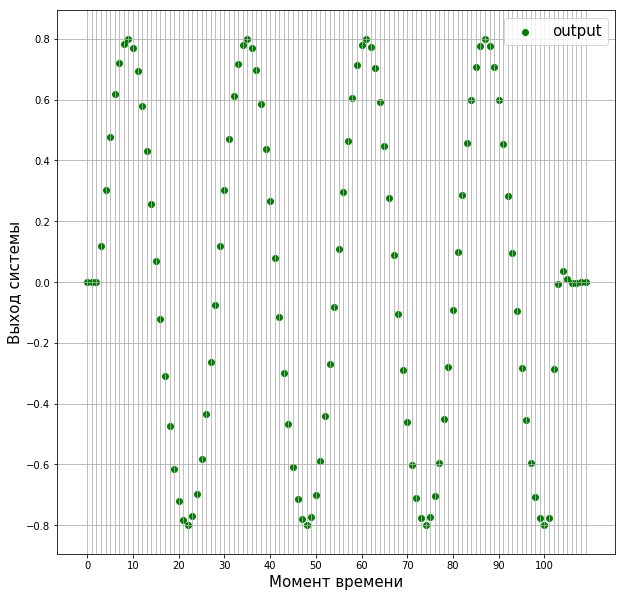

In [164]:
plot_discrete_output(output=train_dataset[0][1])

In [165]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [166]:
train(model, 100, train_dataloader)

epoch 0, mse 0.20124307014048098
epoch 1, mse 0.09056547589600086
epoch 2, mse 0.04088577220216393
epoch 3, mse 0.016089665764011444
epoch 4, mse 0.005278839195379987
epoch 5, mse 0.0018752305587986485
epoch 6, mse 0.0009380601771408692
epoch 7, mse 0.0006265969591913744
epoch 8, mse 0.0005443501740228384
epoch 9, mse 0.00046354238205822187
epoch 10, mse 0.00046700365608558057
epoch 11, mse 0.0004873857019993011
epoch 12, mse 0.0007808689822559245
epoch 13, mse 0.0004933777985570486
epoch 14, mse 0.0003795850534515921
epoch 15, mse 0.0003412439691601321
epoch 16, mse 0.0004580412508221343
epoch 17, mse 0.0006975886144209653
epoch 18, mse 0.0007596087775891647
epoch 19, mse 0.0004685292880458292
epoch 20, mse 0.00035380750166950746
epoch 21, mse 0.0003490905121725518
epoch 22, mse 0.0005806361285794992
epoch 23, mse 0.00034785306444973685
epoch 24, mse 0.00019199486636352957
epoch 25, mse 0.0003326055902289227
epoch 26, mse 0.0005626596487127245
epoch 27, mse 0.0007731670014618431
epoch

In [167]:
test_dataset = generate_data(
    control_sys=system,
    impact_time=100,
    cooldown_time=10,
    n_samples=1000,
    input_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.1, high=1)) / 2
)

In [168]:
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [169]:
test(model, test_dataloader)

0.00031482705673806775

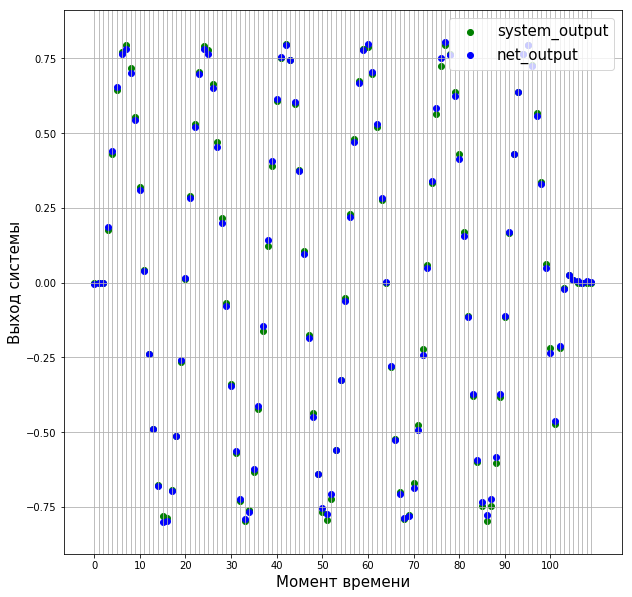

In [175]:
plot_discrete_output(
    system_output=test_dataset[5][1],
    net_output=model(test_dataset[5][0]),
    file_name='high_freq.png'
)

### lstm

In [186]:
class ControlRNN(nn.Module):
    def __init__(self, window_size, layer_input_size, hidden_size, output_size, num_layers=2):
        assert window_size % layer_input_size == 0
        super().__init__()
        self.reccurency = window_size // layer_input_size
        self.layer_input_size = layer_input_size
        
        self.layers = nn.ModuleList()
        self.layers.append(
            nn.LSTM(
                input_size=layer_input_size,
                hidden_size=hidden_size,
                num_layers=num_layers
            )
        )
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, window_data):
        hidden, _ = self.layers[0](window_data.view(-1, self.reccurency, self.layer_input_size).transpose(0, 1))
        last_hidden = hidden[-1, :, :]
        return self.layers[1](last_hidden)

In [66]:
def generate_data_for_rnn(
    control_sys,
    impact_time,
    n_signals,
    n_samples_per_signal,
    sample_u_size,
    sample_response_size,
    u_signal_generation_func
):
    samples_u = list()
    samples_response = list()
    for _ in range(n_signals):
        u = u_signal_generation_func(impact_time)
        response = control.forced_response(control_sys, T=np.arange(impact_time), U=u)[1][0]
        for _ in range(n_samples_per_signal):
            start = np.random.randint(
                low=0,
                high=impact_time - sample_u_size
            )
            fin = start + sample_u_size
            samples_u.append(torch.tensor(u[start: fin], requires_grad=True).float())
            samples_response.append(torch.tensor(response[fin - sample_response_size: fin], requires_grad=True).float())
    
    return ControlDataset(samples_u, samples_response)

In [144]:
train_dataset = generate_data_for_rnn(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=10,
    sample_u_size=100,
    sample_response_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [187]:
model = ControlRNN(
    window_size=100, layer_input_size=20, hidden_size=50, output_size=20, num_layers=2
)

In [188]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [189]:
train(model, 30, train_dataloader, nn.MSELoss())

epoch 0, mse 0.15836706114001572
epoch 1, mse 0.00464276060112752
epoch 2, mse 0.001550496233976446
epoch 3, mse 0.000738812628260348
epoch 4, mse 0.00042809585138456894
epoch 5, mse 0.0003274975286331028
epoch 6, mse 0.0002630976055661449
epoch 7, mse 0.000192737319302978
epoch 8, mse 0.00016280414936773013
epoch 9, mse 0.00014939727989258245
epoch 10, mse 0.00011345852974045556
epoch 11, mse 0.00010856158307433361
epoch 12, mse 9.564468979078811e-05
epoch 13, mse 0.00015642303114873357
epoch 14, mse 8.461068513497594e-05
epoch 15, mse 6.941056104551535e-05
epoch 16, mse 6.198747281814576e-05
epoch 17, mse 5.787626001620083e-05
epoch 18, mse 6.797266863941332e-05
epoch 19, mse 5.928137194132432e-05
epoch 20, mse 5.434478714960278e-05
epoch 21, mse 4.211521983961575e-05
epoch 22, mse 3.897620603311225e-05
epoch 23, mse 4.1011139655893204e-05
epoch 24, mse 4.484406364099413e-05
epoch 25, mse 4.5342172306845896e-05
epoch 26, mse 4.6168617554940287e-05
epoch 27, mse 3.5196701992390446e-05

In [190]:
test_dataset = generate_data_for_rnn(
    control_sys=system,
    impact_time=1000,
    n_signals=100,
    n_samples_per_signal=10,
    sample_u_size=100,
    sample_response_size=20,
    u_signal_generation_func=lambda x: np.sin(np.arange(x) * np.random.uniform(low=0.05, high=0.1)) / 2
)

In [191]:
test(model, DataLoader(test_dataset, batch_size=10, shuffle=True), nn.MSELoss())

8.529024114977801e-05

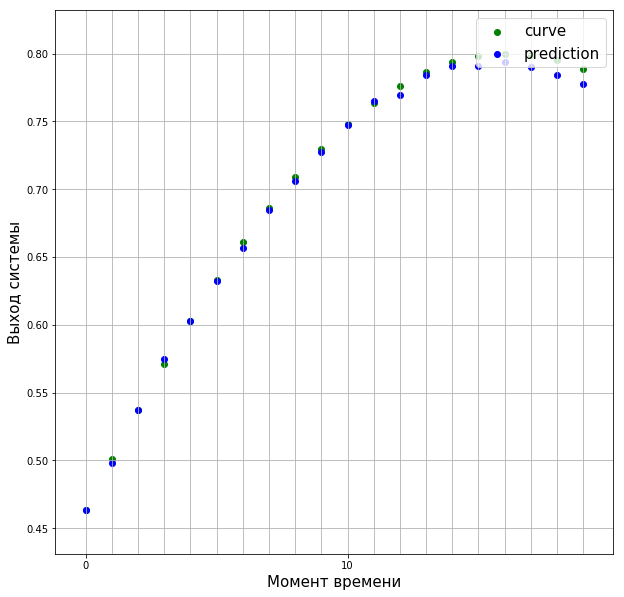

In [196]:
plot_discrete_output(
    curve=test_dataset[4][1],
    prediction=model(test_dataset[4][0])
)